# Tackle Overfitting with Data Augmentation

Welcome, I will be using the famous `cats vs dogs` dataset to train a model that can classify images of dogs from images of cats. For this, I will create my own Convolutional Neural Network in Tensorflow and leverage Keras' image preprocessing utilities, more so this time around since Keras provides excellent support for augmenting image data.

In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-06-19 04:05:15--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 96.6.160.229, 2600:1409:9800:f90::317f, 2600:1409:9800:f86::317f
Connecting to download.microsoft.com (download.microsoft.com)|96.6.160.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  65.6MB/s    in 12s     

2023-06-19 04:05:28 (64.0 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



Now the images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [ ]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


**Expected Output:**

```
There are 12500 images of dogs.
There are 12500 images of cats.
```

You will need a directory for cats-v-dogs, and subdirectories for training
and validation. These in turn will need subdirectories for 'cats' and 'dogs'. To accomplish this, complete the `create_train_val_dirs` below:

In [ ]:
# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
  train_dataset = os.path.join(root_path, 'training')
  os.makedirs(train_dataset)

  valid_dataset = os.path.join(root_path, 'validation')
  os.makedirs(valid_dataset)

  cats_train = os.path.join(train_dataset, 'cats')
  os.makedirs(cats_train)

  dogs_train = os.path.join(train_dataset, 'dogs')
  os.makedirs(dogs_train)

  cats_valid = os.path.join(valid_dataset, 'cats')
  os.makedirs(cats_valid)

  dogs_valid = os.path.join(valid_dataset, 'dogs')
  os.makedirs(dogs_valid)

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs


**Expected Output (directory order might vary):**

``` txt
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs

```

In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  data_source = os.listdir(SOURCE_DIR)
  len_training = int(len(data_source)*SPLIT_SIZE)
  len_validation = int(len(data_source) - len_training)
  random_pick_training = random.sample(data_source, len_training)
  random_pick_validation = random.sample(data_source, len_validation)

  for file in random_pick_training:
    source = os.path.join(SOURCE_DIR, file)
    destination = os.path.join(TRAINING_DIR, file)
    shutil.copyfile(source, destination)

  for file in random_pick_validation:
    source = os.path.join(SOURCE_DIR, file)
    destination = os.path.join(VALIDATION_DIR, file)
    shutil.copyfile(source, destination)

  for file in os.listdir(TRAINING_DIR):
    file_path = os.path.join(TRAINING_DIR, file)
    if os.path.getsize(file_path) == 0:
      print(f'file {file} is zero length, so ignoring')
      os.remove(file_path)

In [ ]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits. Check that the number of images matches the expected output.
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

file 666.jpg is zero length, so ignoring


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


**Expected Output:**

```
666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation
```

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory='/tmp/cats-v-dogs/training',
                                                      batch_size=225,
                                                      class_mode='binary',
                                                      target_size=(150,150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory='/tmp/cats-v-dogs/validation',
                                                                batch_size=225,
                                                                class_mode='binary',
                                                                target_size=(150,150))
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


**Expected Output:**

```
Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
```


In [ ]:
def create_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  from tensorflow.keras.optimizers import RMSprop
  model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

Now it is time to train your model!

Note: You can ignore the `UserWarning: Possibly corrupt EXIF data.` warnings.

In [ ]:
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/20
 30/100 [========>.....................] - ETA: 1:58 - loss: 0.7016 - accuracy: 0.5213

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


100/100 [==============================] - 184s 2s/step - loss: 0.6888 - accuracy: 0.5481 - val_loss: 0.6855 - val_accuracy: 0.5740
Epoch 2/20
100/100 [==============================] - 179s 2s/step - loss: 0.6627 - accuracy: 0.5963 - val_loss: 0.6512 - val_accuracy: 0.6408
Epoch 3/20
100/100 [==============================] - 181s 2s/step - loss: 0.6392 - accuracy: 0.6269 - val_loss: 0.6007 - val_accuracy: 0.6856
Epoch 4/20
100/100 [==============================] - 179s 2s/step - loss: 0.6144 - accuracy: 0.6545 - val_loss: 0.5831 - val_accuracy: 0.7076
Epoch 5/20
100/100 [==============================] - 181s 2s/step - loss: 0.5964 - accuracy: 0.6769 - val_loss: 0.5319 - val_accuracy: 0.7280
Epoch 6/20
100/100 [==============================] - 183s 2s/step - loss: 0.5868 - accuracy: 0.6894 - val_loss: 0.6234 - val_accuracy: 0.6408
Epoch 7/20
100/100 [==============================] - 182s 2s/step - loss: 0.5664 - accuracy: 0.7022 - val_loss: 0.5294 - val_accuracy: 0.7228
Epoch 8/20

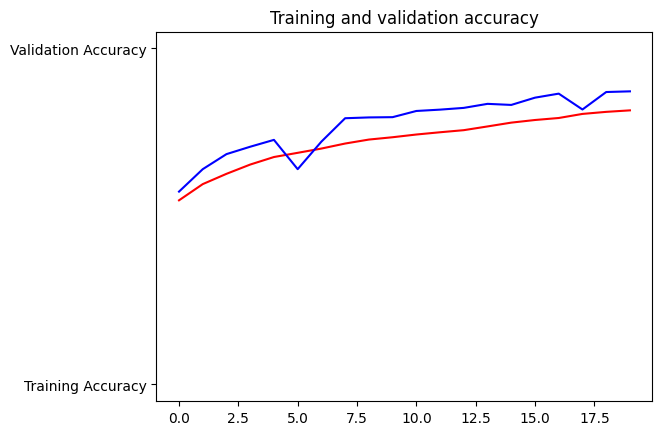

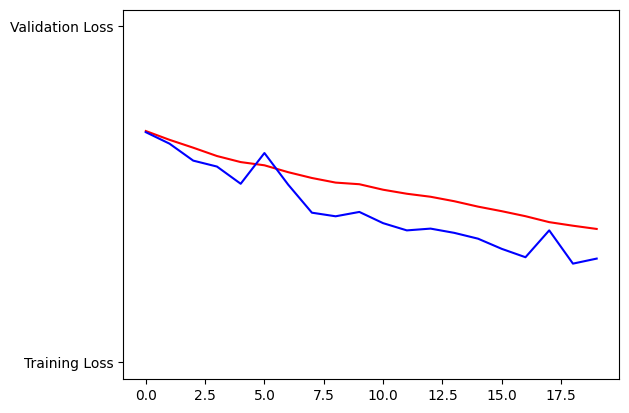

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
def download_history():
  import pickle
  from google.colab import files

  with open('history_augmented.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history_augmented.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>